In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy as sp
from scipy.signal import savgol_filter

%matplotlib inline

In [2]:
!pip install --user seaborn

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl


In [5]:
sys.path.insert(0, "/Users/rusi2317/.local/lib/python3.6/site-packages/")

In [6]:
import seaborn as sns

In [2]:
##path to local library site
pathtositepackages='/Users/rusi2317/.local/lib/python3.6/site-packages/'
sys.path.append(os.path.abspath(pathtositepackages))

##install required modules using pip3 install 
!pip3 install --user scipy

# Expanding regions from Tfit bed

1. You can use merged Tfit bed files or individual bed file.

    a. Regions can merged using bedtools.
    
    b. The centers "mu" are reassigned 
        
    c. Merged regions were expanded to 3kb (xkb).
    
    d. The new regions were saved as a bed file.

In [3]:
def get_tfit_windows(bedfile, outdir, sample_name, window = 1500 ):
    '''This function takes in bed files from Tfit and  redefines mu and extends the window
    '''

    ##takes in Tfit regions/calls or any other bed file with chr, start, stop columns 
    bed = pd.read_csv(bedfile, sep = '\t',header=None,comment='#')

    ##select the coordinate colmuns only    
    bed_df = bed.loc[:, 0:2]
    bed_df.columns = ["chr", "start", "stop"]

    ##redefine mu to get new start and stop coordinates
    bed_df["start_new"] = bed_df.apply(lambda x: round((x["start"] + x["stop"])/2), axis=1)

    bed_df["stop_new"] = bed_df.apply(lambda x: x["start_new"] + 1, axis = 1)

    ##the -1500 position from "origin"
    bed_df["start"] = bed_df.apply(lambda x: x["start_new"] - int(window), axis=1)

    ##the 1500 position from the "origin"
    bed_df["stop"] = bed_df.apply(lambda x: x["stop_new"] + int(window), axis=1)

    ##saving the new bedfile
    bed_df.to_csv(outdir + sample_name + '_window.bed', sep='\t',
                    columns=["chr","start","stop"],
                    header = False, index = False)   

In [4]:
##get_tfit_wondows(input_bed, output_dir, label_for_files)
get_tfit_windows("/scratch/Shares/dowell/NascentDB/processed/Allen2014/tfit/SRR1105736.tfit_bidirs.bed",
                "/Users/rusi2317/projects/gc_content/output/Allen2014/", "Allen2014_new")


# Get regions from genome


```sh
#!/bin/bash                                                                                                           
###Name the job                                                                                                       
#SBATCH --job-name=get_sequences 

###Specify the queue                                                                         
#SBATCH -p short                                                                                                       

###Specify WallTime                                                                          
#SBATCH --time=00:10:00                                                                                               

### Specify the number of nodes/cores                                                        
#SBATCH --nodes=1                                
#SBATCH --ntasks=1                                                                                                     

### Allocate the amount of memory needed                               
#SBATCH --mem=2gb                                                                                                      
### Setting to mail when the job is complete                           
#SBATCH --error /scratch/Users/username/path/to/e_and_o/%x.err                                             
#SBATCH --output /scratch/Users/username/path/to/e_and_o/%x.out                                                          
### Set your email address  
#SBATCH --mail-type=ALL          
#SBATCH --mail-user=username@host.edu  

module purge
module load bedtools/2.25.0


bedtools getfasta -fi /scratch/Shares/dowell/nascent/hg38/hg38.fa -bed /path/to/bedfile.bed  -fo /path/to/output.fa


```

# Count bases across sequences

In [5]:
fa = "/Users/rusi2317/projects/gc_content/output/Allen2014/Allen2014_new_window.fa" ##from the output of teh above cell

sequences = []
sequence_names = []

with open(fa) as fasta:
    for line in fasta:
        line = line.strip("\n")
        if ">" not in line:
            sequences.append(line)
        else:
            sequence_names.append(line)

In [6]:
def count_bases(seqs, outdir, sample_name, window=1500): 
    '''calculate per position base composition across multiple 
    sequences of even length. 
    
    Parameters
    ----------
    seqs : list or array
        sequences of even lengths
        
    outdir : str
        path for out directory
    
    sample_name : str
        name of sample
        
    window : int
        length of sequences (default=1500)
        
    Returns
    -------
    anew,tnew,cnew,gnew,nnew : list of lists
        normalized base counts for every position across all
        sequences
    
    '''
    
    sequence_length = int(2*int(window)+1)
    
    ##initialize lists with len of sequences
    a = [0]*sequence_length
    t = [0]*sequence_length
    c = [0]*sequence_length
    g = [0]*sequence_length
    n = [0]*sequence_length

    ##for each positions count the occurance of each base
    ##across all sequences in the the input list
    for i in range(sequence_length):
        ##initialize counters
        count_a = 0
        count_t = 0
        count_c = 0
        count_g = 0
        count_n = 0
        for j in seqs:
            if j[i] == "a" or j[i] == "A":
                count_a = count_a + 1
                a[i] = count_a 
            elif j[i] == "t" or j[i] == "T":
                count_t = count_t + 1
                t[i] = count_t
            elif j[i] == "g" or j[i] == "G":
                count_g = count_g + 1 
                g[i] = count_g
            elif j[i] == "c" or j[i] == "C":
                count_c = count_c + 1   
                c[i] = count_c
            elif j[i] == "n" or j[i] == "N":
                count_n = count_n + 1   
                n[i] = count_n 
                
    ##evenly distribute Ns across all bases
    nnew = [x / 4 for x in n]

    anew = [ai + bi for ai,bi in zip(a,nnew)]
    tnew = [ai + bi for ai,bi in zip(t,nnew)]
    gnew = [ai + bi for ai,bi in zip(g,nnew)]
    cnew = [ai + bi for ai,bi in zip(c,nnew)]

    ##get the base frequencies of all bases
    anew = [x / len(seqs) for x in anew]
    tnew = [x / len(seqs) for x in tnew]
    cnew = [x / len(seqs) for x in cnew]
    gnew = [x / len(seqs) for x in gnew]
    
    base_df = pd.DataFrame({'A': anew,
                            'T': tnew,
                            'G': cnew,
                            'C': gnew})

    base_df.to_csv(outdir + sample_name+ '_base_content.tsv', sep='\t')
    
    return anew, tnew, cnew, gnew, nnew

In [7]:
counts = count_bases(sequences, "/Users/rusi2317/projects/gc_content/output/Allen2014/",
                    "Allen2014_new")

# Plot the distributions

Text(0.5,0.98,'sample_name')

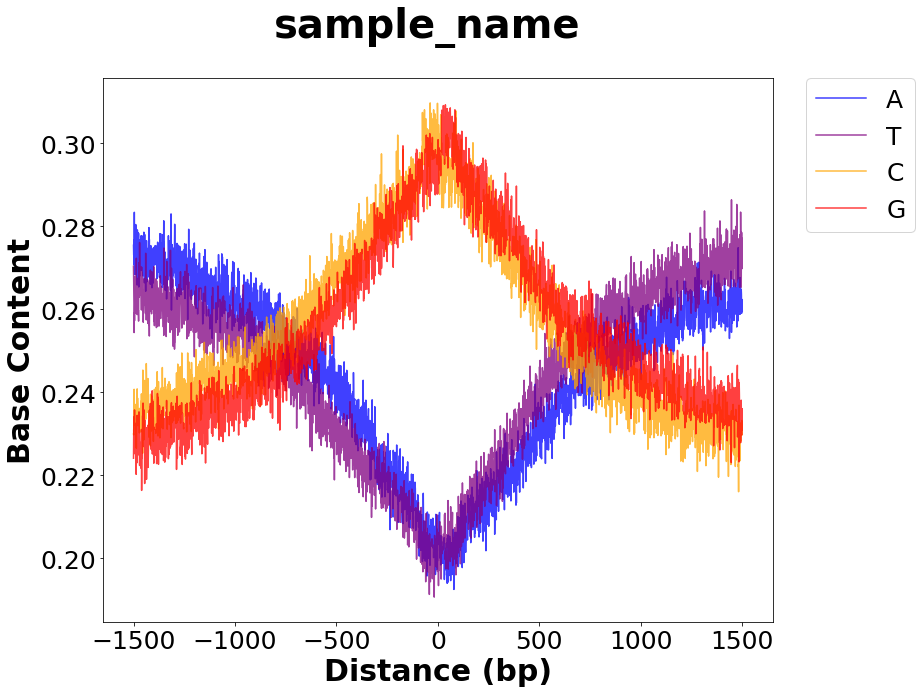

In [9]:
window=1500

##get positions                                                                                                                                                    
starting=int(window)
stopping=int(window)+1
positions = np.arange(-starting,stopping,1)

#########################################                                                                                                                          
###Line plot for each base on one grid###                                                                                                                          
#########################################                                                                                                                          
plt.figure(figsize=(12,10))
gs = plt.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.plot(positions,counts[0],color='blue', alpha=0.75, label='A')
ax0.plot(positions,counts[1],color='purple', alpha=0.75, label='T')
ax0.plot(positions,counts[2],color='orange', alpha=0.75, label = 'C')
ax0.plot(positions,counts[3],color='red', alpha=0.75, label = 'G')
ax0.set_xlabel('Distance (bp)',fontsize=30,fontweight='bold')
ax0.set_ylabel('Base Content',fontsize=30,fontweight='bold')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(bbox_to_anchor=(1.05, 1),fontsize = 25, loc=2, borderaxespad=0.)
plt.suptitle("sample_name", fontsize=40, fontweight='bold')


Text(0.5,0.98,'sample_name')

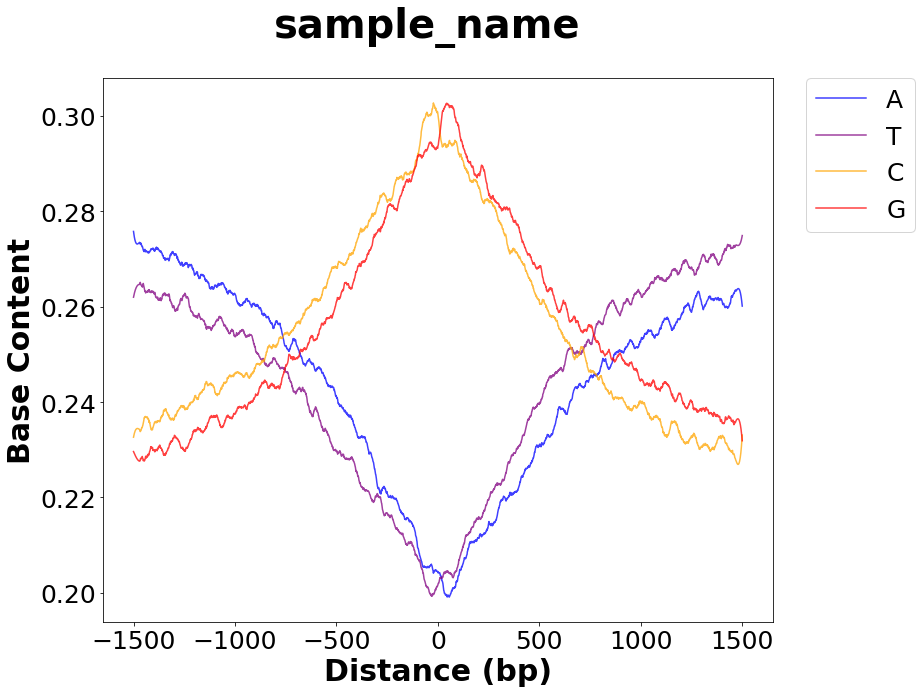

In [10]:
#####################################################                                                                                                              
###Smooth the frequencies for better visualization###                                                                                                              
#####################################################                                                                                                              

a1 = savgol_filter(tuple(np.array(counts[0])), 61, 3) # window size 61, polynomial order 3                                                                 
t1 = savgol_filter(tuple(np.array(counts[1])), 61, 3)
c1 = savgol_filter(tuple(np.array(counts[2])), 61, 3)
g1 = savgol_filter(tuple(np.array(counts[3])), 61, 3)

plt.figure(figsize=(12,10))
gs1 = plt.GridSpec(1, 1)
ax1 = plt.subplot(gs1[0])

ax1.plot(positions,a1,color='blue', alpha=0.75, label='A')
ax1.plot(positions,t1,color='purple', alpha=0.75, label='T')
ax1.plot(positions,c1,color='orange', alpha=0.75, label = 'C')
ax1.plot(positions,g1,color='red', alpha=0.75, label = 'G')
ax1.set_xlabel('Distance (bp)',fontsize=30,fontweight='bold')
ax1.set_ylabel('Base Content',fontsize=30,fontweight='bold')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(bbox_to_anchor=(1.05, 1),fontsize = 25, loc=2, borderaxespad=0.)
plt.suptitle("sample_name", fontsize=40, fontweight='bold')
